<a href="https://colab.research.google.com/github/wolffg7/deeplearning1/blob/main/AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop


from urllib.request import urlretrieve 
from collections import Counter 

from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [2]:
urlretrieve("https://www.gutenberg.org/cache/epub/70590/pg70590.txt", 'darkrecess.txt')
darkrecess = open("darkrecess.txt", encoding='utf-8').read().lower()

urlretrieve("https://www.gutenberg.org/cache/epub/70594/pg70594.txt", 'europe.txt')
europe = open("europe.txt", encoding='utf-8').read().lower()

print(darkrecess[:100])
print(europe[:100]) 

﻿the project gutenberg ebook of dark recess, by george o. smith

this ebook is for the use of anyone
﻿the project gutenberg ebook of beautiful europe--the engadine, by
spencer musson

this ebook is for


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

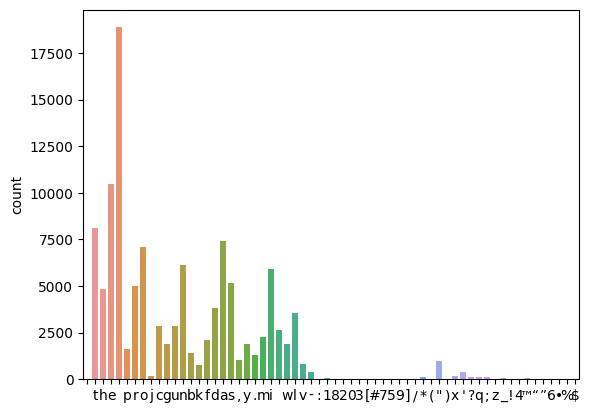

In [3]:
dr = Counter(darkrecess)
ax = sns.countplot(x=list(dr.elements()))
plt.show() 

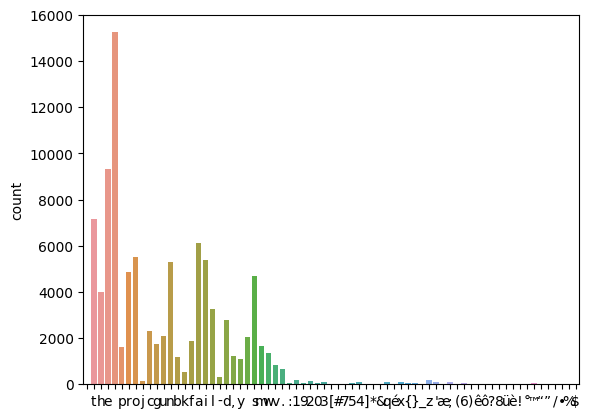

In [4]:
e = Counter(europe)  
ax2 = sns.countplot(x=list(e.elements()))
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [5]:
sequence_length = 60 

darkrecess_chars = list(set(darkrecess))
europe_chars = list(set(europe)) 

all_chars = set(darkrecess_chars) | set(europe_chars)

alphabet_length = len(all_chars) 

import numpy as np
from keras.utils import to_categorical

char_to_index = {char: index for index, char in enumerate(all_chars)}

In [6]:
def sequence_to_one_hot(sequence, char_to_index, alphabet_length):
    one_hot = np.zeros((len(sequence), alphabet_length))
    for i, char in enumerate(sequence):
        if char in char_to_index:
            index = char_to_index[char]
            one_hot[i, index] = 1
    return one_hot

In [7]:
def generate_data(text, sequence_length, char_to_index, alphabet_length, author):

    sentences  = [] 
    next_chars = []

    for i in range(0, len(text)-sequence_length, 10):
      sentences.append(text[i:i+sequence_length])
      next_chars.append(text[i+sequence_length])

    print('Number of training samples:', len(sentences))

    X = np.zeros((len(sentences), sequence_length, alphabet_length))
    Y = np.zeros(len(sentences))
    for i in range(len(sentences)):
        sequence = text[i:i+sequence_length]
        X[i] = sequence_to_one_hot(sequence, char_to_index, alphabet_length)
        Y[i] = 0 if author == "darkrecess" else 1
    return X, Y

In [8]:
X1, Y1 = generate_data(darkrecess, sequence_length, char_to_index, alphabet_length, "darkrecess") 
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.2, random_state=42)

X2, Y2 = generate_data(europe, sequence_length, char_to_index, alphabet_length, "europe")
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=42)

Number of training samples: 11483
Number of training samples: 9600


## Data splitting
Split the data into train, validate and test sets. Make 

In [9]:
X_train = np.concatenate((X_train1, X_train2))
X_test = np.concatenate((X_test1, X_test2))
Y_train = np.concatenate((Y_train1, Y_train2))
Y_test = np.concatenate((Y_test1, Y_test2))

num_train_samples = X_train.shape[0]

train_indices = np.random.permutation(num_train_samples)

X_train = X_train[train_indices]
Y_train = Y_train[train_indices]

train_ratio  = 0.8
train_length = X_train.shape[0]
train_split  = int(train_ratio*train_length)
X_valid, Y_valid = X_train[train_split:], Y_train[train_split:]
X_train, Y_train = X_train[:train_split], Y_train[:train_split]

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [19]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[-2], X_train.shape[-1]))) 
model.add(Dense(1, activation ='sigmoid')) 

## Model training
Train the model and apply early stopping.

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
)


In [21]:
network_history = model.fit(X_train, Y_train, 
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,                             
                            epochs=100, 
                            verbose=1, 
                            callbacks=[es])

Epoch 1/100
106/106 [==============================] - 46s 391ms/step - loss: 0.5919 - accuracy: 0.6651 - val_loss: 0.4893 - val_accuracy: 0.7558
Epoch 2/100
106/106 [==============================] - 26s 247ms/step - loss: 0.4534 - accuracy: 0.7655 - val_loss: 0.4765 - val_accuracy: 0.7303
Epoch 3/100
106/106 [==============================] - 26s 243ms/step - loss: 0.4060 - accuracy: 0.7866 - val_loss: 0.3868 - val_accuracy: 0.7964
Epoch 4/100
106/106 [==============================] - 23s 218ms/step - loss: 0.3674 - accuracy: 0.8174 - val_loss: 0.3511 - val_accuracy: 0.8278
Epoch 5/100
106/106 [==============================] - 25s 236ms/step - loss: 0.2922 - accuracy: 0.8620 - val_loss: 0.2440 - val_accuracy: 0.8853
Epoch 6/100
106/106 [==============================] - 25s 236ms/step - loss: 0.2361 - accuracy: 0.8971 - val_loss: 0.1853 - val_accuracy: 0.9265
Epoch 7/100
106/106 [==============================] - 24s 230ms/step - loss: 0.1396 - accuracy: 0.9417 - val_loss: 0.1285 -

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [22]:
preds = model.predict(X_test)
cm = confusion_matrix(Y_test, np.rint(preds))

print("Accuracy:",accuracy_score(Y_test, np.rint(preds)))
print("Precision:", precision_score(Y_test, np.rint(preds)))
print("Recall:", recall_score(Y_test, np.rint(preds), average='macro'))
print("F1:", f1_score(Y_test, np.rint(preds), average='macro'))


132/132 [==============================] - 5s 31ms/step
Accuracy: 0.978894949015888
Precision: 0.9770713913496613
Recall: 0.9787035399434044
F1: 0.9787240000895681


In [23]:
sum(np.rint(preds)) == len(preds)

array([False])

## Confusion matrix
Calculate and display the confusion matrix.

<Axes: >

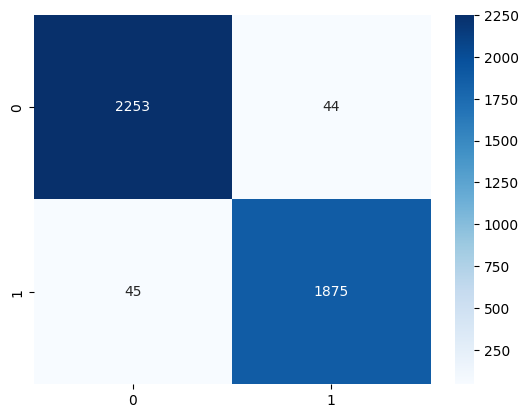

In [24]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')